In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats as stats
from PIL import Image
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn.preprocessing import MinMaxScaler
import matplotlib.image as mpimg
from sklearn.manifold import MDS
from util_func import *
import nibabel as nib

result_folder = '/home/dasom/SM_DATA/Distributed/files'

roi_mask = nib.load(f'{result_folder}/BNA_3mm_atlas.nii.gz').get_fdata()
brain_mask = nib.load(f'{result_folder}/MNI152NLin2009cAsym_3mm_mask.nii.gz').get_fdata()
gm_idx = np.where(roi_mask[brain_mask > 0] > 0)[0]

hs = mpimg.imread(f'{result_folder}/c1.png')
mw = mpimg.imread(f'{result_folder}/c2.png')
jm = mpimg.imread(f'{result_folder}/c3.png')
ji = mpimg.imread(f'{result_folder}/c4.png')
jw = mpimg.imread(f'{result_folder}/c5.png')
ky = mpimg.imread(f'{result_folder}/c6.png')
colors = ['red','yellow','blue','cyan','magenta','black']
char_face = [hs,mw,jm,ji,jw,ky]

In [4]:
def visualize_graph(mat, rotate = None, save_path = None, zoom_in = 1):

    cn = 6

    aa = np.ones((cn, cn))
    aa[np.diag_indices(cn)] = 0 
    aa = aa.astype('bool')

    raw = -mat
    mms1 = MinMaxScaler(feature_range=(0.001,1)).fit(raw[aa].reshape(-1,1))
    minmax = mms1.transform(raw[aa].reshape(-1,1))[:,0]
    raw = np.zeros((cn, cn))
    raw[aa] = minmax

    dm_raw = raw
    A = dm_raw
    A_2D = A + A.T

    color_map = plt.cm.YlOrRd(np.linspace(0, 1, 30))
    x_sort = np.argsort(-raw[aa])

    mds = MDS(n_components = 2, dissimilarity='precomputed', random_state=2022, normalized_stress = 'auto')
    X_r = mds.fit(A_2D).embedding_

    if rotate is not None:
        raw = -rotate
        mms1 = MinMaxScaler(feature_range=(0.001,1)).fit(raw[aa].reshape(-1,1))
        minmax = mms1.transform(raw[aa].reshape(-1,1))[:,0]
        raw = np.zeros((cn, cn))
        raw[aa] = minmax

        dm_raw = raw
        A = dm_raw
        A_2D = A + A.T

        color_map = plt.cm.YlOrRd(np.linspace(0, 1, 30))
        x_sort = np.argsort(-raw[aa])

        mds = MDS(n_components = 2, dissimilarity='precomputed', random_state=2022, normalized_stress = 'auto')
        X_rotate = mds.fit(A_2D).embedding_
        X_r = translate_mean_to_center(X_r)
        X_r = spatial_normalize(X_r)
        X_r = rotation_shape(X_rotate, X_r)
    else:
        X_r = translate_mean_to_center(X_r)
        X_r = spatial_normalize(X_r)

    visualization_factor = 500/np.round(np.max(np.abs(X_r)), 2)
    X_r = X_r * visualization_factor * zoom_in

    stim_size = visualization_factor/6
    plt.figure(figsize = [15, 15])
    plt.xlim([-visualization_factor,visualization_factor])
    plt.ylim([-visualization_factor,visualization_factor])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

    style = "Simple, tail_width=0.5, head_width=10, head_length=30"

    ###### entire space
    count = 0
    for id1 in range(cn):
        for id2 in range(cn):
            if id1 != id2:
                if not (((id1 == 5) and (id2 == 4)) or ((id1 == 4) and (id2 == 5)) or ((id1 == 0) and (id2 == 5))):
                    kw = dict(arrowstyle=style, color = color_map[np.where(x_sort == count)[0]], linewidth = (1.1-raw[id1,id2])*3+1, zorder = 0, alpha = 1)
                    a1 = patches.FancyArrowPatch((X_r[id1,0],X_r[id1,1]),(X_r[id2,0],X_r[id2,1]), connectionstyle="arc3,rad=.1", **kw)
                    plt.gca().add_patch(a1)

                count += 1
    for i in range(cn):
        plt.imshow(char_face[i], extent=[X_r[i,0]-stim_size/2,X_r[i,0]+stim_size/2,X_r[i,1]-stim_size/2,X_r[i,1]+stim_size/2], zorder = 1)

    if save_path != None:
        plt.savefig(save_path, transparent=True)

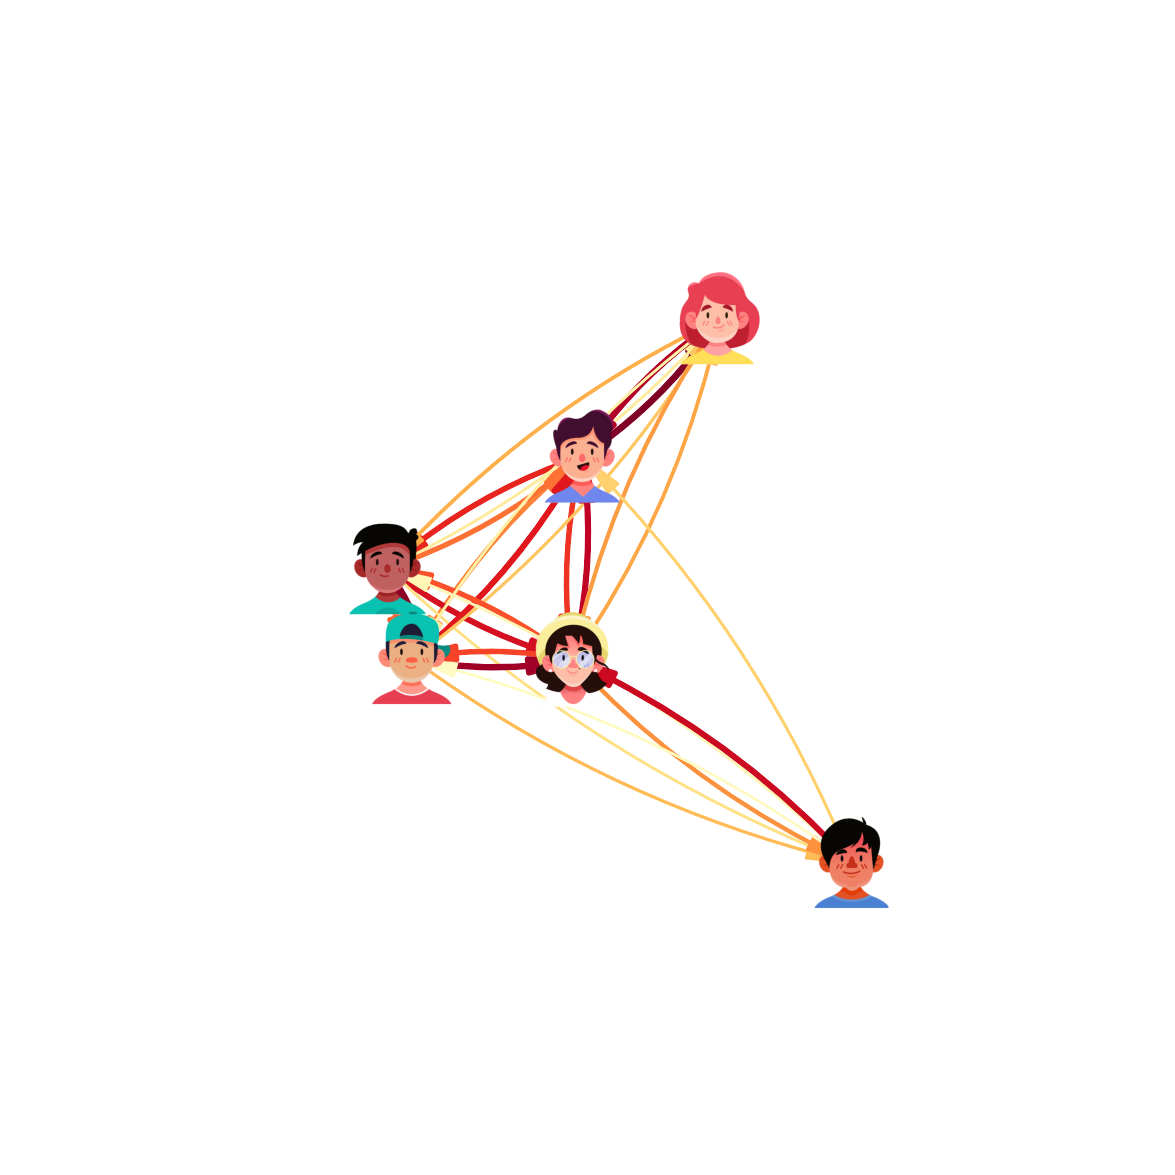

In [9]:
relationship_visualization = np.load(f'{result_folder}/Behavioral_latent_Y_representation.npy')
subj = 0
dim = 0

rel = np.zeros((6,6))
cn = 6

###
# aa = np.ones((cn, cn))
# aa[np.diag_indices(cn)] = 0 
# aa = aa.astype('bool')
# rel[aa] = relationship_visualization[subj][dim]
###
rel = relationship_visualization[subj][dim]

save_path = 'save_path'
visualize_graph(rel, rotate = None,
                save_path = None, zoom_in = 1)

In [33]:
import cv2
import numpy as np
import glob
import os

# path = sorted(os.listdir('/home/dasom/Dropbox/ubuntu-window/미팅자료/social_structure/Results/4.movie_event_by_event/Event_recon_cumul'))
img_array = []
for idx in range(61):
    filename = f'/home/dasom/Dropbox/ubuntu-window/미팅자료/social_structure/Results/4.movie_event_by_event/Event_recon/Event{idx+1}_social_relationship.png'
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('/home/dasom/Dropbox/ubuntu-window/미팅자료/social_structure/Results/4.movie_event_by_event/Event_recon.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 2, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()